In [125]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [126]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Input size = 2 (t,x)
layer_sizes = [2,1024,1024,1024,1]
step_size = 0.01
num_epochs = 1000
batch_size = 128
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [127]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image

  w, b = params[0]
  outputs = jnp.dot(w, activations) + b
  activations = relu(outputs)
  
  for w, b in params[1:-2]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs) + activations

  w, b = params[-2]
  outputs = jnp.dot(w, activations) + b
  activations = jnp.sin(outputs) + activations
  
  final_w, final_b = params[-1]
  yhat = jnp.dot(final_w, activations) + final_b
  return yhat

In [128]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (2,))
preds = predict(params, random_flattened_image)
print(preds)
print(preds.shape)

[0.02207097]
(1,)


In [129]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

In [130]:
import numpy as np

results = np.load('tw_train.npz')
data = results['data']
stddev = results['std']
mean = results['mean']

def loss(params, inputs, targets):
  preds = batched_predict(params, inputs)
  return jnp.mean( (preds - targets) ** 2 )

def exact():
  # we discretize time in [0,70] with 20 points
  # space in [0,1] with 300 points
  NT = 20 
  NX = 300

  key = random.PRNGKey(0)

  x = random.uniform(key,shape=(NX,))
  t = jnp.linspace(0,70,NT,endpoint=False)

  xx,tt=jnp.meshgrid(x,t)

  omega = 10
  c = 0.12/10
  x0 = 0.1

  # u = np.exp()
  u = jnp.exp(-1000.0*(xx-x0-c*tt)**2)*jnp.sin(omega*(xx-x0-c*tt))
  return ((xx.flatten()-mean[0])/stddev[0], \
          (tt.flatten()-mean[1])/stddev[1], \
           (u.flatten()-mean[2])/stddev[2] )

## This is the test set
x_e, t_e, u_e = exact()



In [131]:
print(x_e.shape)

(6000,)


In [132]:
import tensorflow as tf
import tensorflow_datasets as tfds

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tf.data.Dataset.from_tensor_slices((data[:,0:2], data[:,2].reshape(-1,1))).shuffle(data.shape[0])
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [133]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    # print(x.shape, y.shape)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_loss = loss(params, data[:,0:2], data[:,2].reshape(-1,1))
  test_loss = loss(params, jnp.hstack((x_e.reshape(-1,1), t_e.reshape(-1,1))), u_e.reshape(-1,1))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set error {}".format(train_loss))
  print("Test set error {}".format(test_loss))

Epoch 0 in 8.32 sec
Training set error 0.9999058246612549
Test set error 1.0407929420471191
Epoch 1 in 0.04 sec
Training set error 0.9997188448905945
Test set error 1.0406438112258911
Epoch 2 in 0.03 sec
Training set error 0.999553382396698
Test set error 1.0405179262161255
Epoch 3 in 0.03 sec
Training set error 0.9994215369224548
Test set error 1.0404212474822998
Epoch 4 in 0.03 sec
Training set error 0.9993149042129517
Test set error 1.0403473377227783
Epoch 5 in 0.04 sec
Training set error 0.9992667436599731
Test set error 1.0403656959533691
Epoch 6 in 0.03 sec
Training set error 0.9991742968559265
Test set error 1.0402748584747314
Epoch 7 in 0.03 sec
Training set error 0.9991258978843689
Test set error 1.0401592254638672
Epoch 8 in 0.03 sec
Training set error 0.9990391135215759
Test set error 1.0401586294174194
Epoch 9 in 0.03 sec
Training set error 0.9989688396453857
Test set error 1.0400817394256592
Epoch 10 in 0.04 sec
Training set error 0.998909592628479
Test set error 1.040014

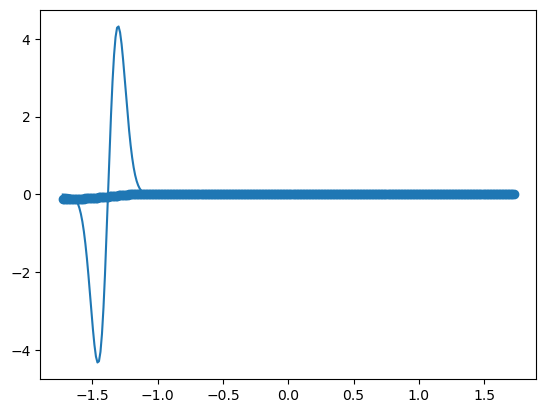

In [ ]:
from matplotlib import pyplot as plt

yplot = batched_predict(params,data[:300,0:2])

plt.figure()
plt.plot(data[:300,0],data[:300,2])
plt.scatter(data[:300,0],yplot)

plt.show()

